In [1]:
# And what is the use of a demo,' 
# thought Kai, 'without structures or explanation?'
#
# github.com/kaibrooks

In [2]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.optimizers import Adam 
from keras.utils.data_utils import get_file
from keras.layers import Dropout # dropout crew 4 lyf
from IPython.display import clear_output # clear plot after each epoch
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np
import random
import sys
import io
import os
import h5py
import matplotlib.pyplot as plt # fancy plots
from matplotlib import pyplot as plt
from datetime import datetime # so we know how much time we've wasted

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.title('training in progress')
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

## try to use the GPU if we can

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


print('TensorFlow version', tf.__version__)
print('Keras version', keras.__version__)
#print('SciPy version', scipy.__version__)
print('Numpy version', np.__version__) 
#print('Pillow version', PIL.__version__) 

Using TensorFlow backend.


TensorFlow version 2.1.0
Keras version 2.2.4-tf
Numpy version 1.18.1


In [3]:
## pick your dataset
# this should be the same name as the .txt file inside /data

source = 'snoop_dups' # default: alice

print('Go go',source)

Go go snoop_dups


In [4]:
## all the settings
epochs = 2000 #60
epochOutput = False
temperature = [0.2, 0.5, 1.0, 1.2]
earlyStop = True

np.seterr(divide='ignore') # ignore divide by zero warnings

# save locations
save_dir = os.path.join(os.getcwd(), 'trained_models')
plot_dir = os.path.join(os.getcwd(), 'plots')

# make sure these folders exist
if not os.path.exists(save_dir): os.mkdir(save_dir)
if not os.path.exists(plot_dir): os.mkdir(plot_dir)


## get text file and parse it

#path = get_file( # use this for http request
#    'afile.txt',
#    origin='http://omega.lul/afile.txt')

# look for a .txt file in /data

path = os.path.join('data', source + '.txt')

print('Loaded',path)

# print sweet ~data~ about the file
with open(path, encoding='utf-8', errors='ignore') as f: # errors=ignore strips non utf-8 chars
    text = f.read().lower()

chars = sorted(list(set(text)))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])

print('corpus length :', len(text))
print('unique chars  :', len(chars))
print('total patterns:', len(sentences))
print('') # empty line

if len(text) < 100000:
    print('corpus should be at least 100K words')
    print('') # empty line
elif len(text) < 1000000:
    print('corpus would be better at 1M words')
    print('') # empty line

    
print('Vectorizing...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print('Done')

Loaded data/snoop_dups.txt
corpus length : 126852
unique chars  : 38
total patterns: 42271

corpus would be better at 1M words

Vectorizing...
Done


In [5]:
## model
# this has NO TEST DATASET

print('Building model...')
#model = Sequential()
#model.add(LSTM(128, input_shape=(maxlen, len(chars))))
#model.add(Dense(len(chars), activation='softmax'))
#optimizer = RMSprop(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer)

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.1))
model.add(LSTM(128))
model.add(Dropout(0.1))
model.add(Dense(len(chars), activation='softmax'))

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer) # metrics=['accuracy']


print('Done')

Building model...
Done


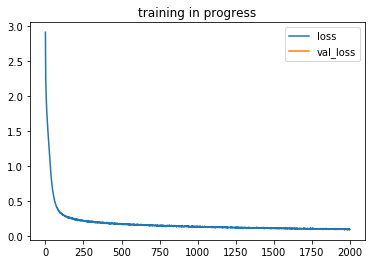

Finished training at 28-Feb-2020 09:40:04
Model summary:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40, 128)           85504     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                4902      
Total params: 221,990
Trainable params: 221,990
Non-trainable params: 0
_________________________________________________________________


In [6]:
# train me
now = datetime.now()
runDate = now.strftime("%Y-%m-%d_%H-%M-%S")
print("Starting training at", runDate, 'UTC') # lets see how long this takes

# things for output while we train
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, _):
    if epochOutput:
        # print text at each epoch
        print()
        print('**************************** Generating text after Epoch: %d ****************************' % epoch)

        start_index = random.randint(0, len(text) - maxlen - 1)
        for temperature in [temperature]:
            print('--------------- temperature: ', temperature, '---------------')

            generated = ''
            sentence = text[start_index: start_index + maxlen]
            generated += sentence
            print('--------------- seed: <', sentence,'>')
            sys.stdout.write(generated)

            for i in range(400):
                x_pred = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(sentence):
                    x_pred[0, t, char_indices[char]] = 1.

                preds = model.predict(x_pred, verbose=0)[0]
                next_index = sample(preds, temperature)
                next_char = indices_char[next_index]

                sentence = sentence[1:] + next_char
                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


# early stopping
# loss, accuracy

if earlyStop:
    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    #es = EarlyStopping(monitor='loss', mode='min', min_delta=1, baseline=0.1)
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=round(epochs*1.1)) # stop early if no progress for 10% of max epochs


mc1 = ModelCheckpoint('trained_models/best_model.h5', monitor='loss', mode='min', save_best_only=True)
mc2 = ModelCheckpoint('trained_models/last_model.h5') # save model each run

history = model.fit(x, y,
          batch_size=128,
          epochs=epochs,
          callbacks=[print_callback, es, mc1, mc2, plot_losses]) # add back es!

then = datetime.now()
print("Finished training at", then.strftime("%d-%b-%Y %H:%M:%S")) # lets see how long this took

print('Model summary:')
model.summary()

In [7]:
## save models and log

# this is where you pay attention to where you mapped the Docker dir to your local dir at run
save_dir = os.path.join(os.getcwd(), 'trained_models')

if not os.path.isdir(save_dir): # make dir if it doesn't exist
    os.makedirs(save_dir)    
    print(save_dir, 'doesn\'t exist, creating it')

print('Saving...') # do this because saving the model takes 5+ seconds sometimes


# name the files
last_name =  source + '_e' + str(epochs) + '_' + runDate + '_trainedmodel_last.h5'
summary_name = source + '_e' + str(epochs) + '_' + runDate + '_modelsummary.txt'
best_name = source + '_e' + str(epochs) + '_' + runDate + '_trainedmodel_best.h5'
weights_name = source + '_e' + str(epochs) + '_' + runDate + '_trainedmodel_weights.h5' # for weights only



# get the best model
saved_model = load_model('trained_models/best_model.h5')

# save best model
model_path = os.path.join(save_dir, best_name)
saved_model.save(model_path)

# save weights only
model_path = os.path.join(save_dir, weights_name)
saved_model.save_weights(model_path)

# save summary
with open(os.path.join(save_dir, summary_name),'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))


print('Saved to ', os.path.join(save_dir), 'as', runDate)
#print('Saved best model at %s ' % os.path.join(save_dir, best_name)) 
#print('Saved summary at %s' % os.path.join(save_dir, summary_name))   


size = os.path.getsize(os.path.join(save_dir, best_name)) # note how big the model is because they're often huge
print('Model file is',round(size/1e+6),'MB')
size = os.path.getsize(model_path) # note how big the model is because they're often huge
print('Weights file is',round(size/1e+6),'MB')

Saving...
Saved to  /tf/notebooks/lstm/trained_models as 2020-02-27_17-08-13
Model file is 3 MB
Weights file is 1 MB


Min: 0.08889148806156502


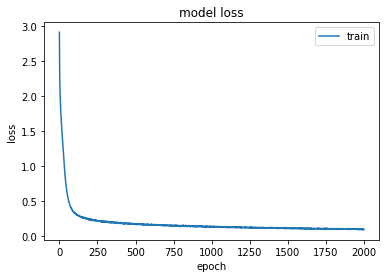

Saved /tf/notebooks/lstm/plots/snoop_dups_2020-02-27_17-08-13_loss.png


In [8]:
## plot training information
# accuracy
#plt.plot(history.history['accuracy']) # kx or similar Matlab commands for plotting
#plt.plot(history.history['val_accuracy'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='lower right')
#plt.show()

# loss
loss_min = np.min(history.history['loss'])

plt.plot(history.history['loss'])
#plt.scatter(loss_min, list(range(1, 200)), 'kx')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(os.path.join(plot_dir, source + '_' + runDate + '_loss.png'))

print('Min:', str(loss_min))
plt.show()


print('Saved', os.path.join(plot_dir, source + '_' + runDate + '_loss.png'))


In [9]:
## load a model for testing

#model_path = os.path.join(save_dir, 'last_model.h5') # external file
#model_path = os.path.join(save_dir, last_name) # last
model_path = os.path.join(save_dir, best_name) # best

model = load_model(model_path)
print('Loaded', model_path)

Loaded /tf/notebooks/lstm/trained_models/snoop_dups_e2000_2020-02-27_17-08-13_trainedmodel_best.h5


In [12]:
## set for the final output
start_index = random.randint(0, len(text) - maxlen - 1)
sentence = text[start_index: start_index + maxlen]
randomizeOut = False
temperature = 0.5 # 0.5? depends on training length
maxChars = 400 # 400 is same as above

#if randomizeOut:
#    generated = ''
#    sentence = text[start_index: start_index + maxlen]
#    generated += sentence

seed = sentence.replace('\n','')
seed = seed.replace('\t','')
print('*** seed: <', seed ,'>')
#sys.stdout.write(generated)

print('\n',seed, end = '')

for i in range(maxChars):
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_indices[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds, temperature)
    next_char = indices_char[next_index]

    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()

*** seed: <  wanna be a motherfuckin hustla ya betta >

  wanna be a motherfuckin hustla ya bettara
ellw on the monts in the mamin em dogg pound now what the heat she solle smakin countted so work the hoess of niggas gotta get shit
niggas with the i brold nigga fuck the light beat is freete
in a on the rack you aint wanna check waz the dreak
your hoase you aint do do but the sound
and hat her they keep i pary compted now thing it real on tout feess
skee she sake it doggystyle
oh i oh i oh i o
